In [178]:
!pip install sklearn
!pip install skforecast

In [179]:
import pandas as pd
import matplotlib.pyplot as plt
import math


# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from warnings import simplefilter

pd.options.mode.chained_assignment = None  # default='warn'import pandas as pd
pd.set_option('display.precision', 5)

In [180]:
df = pd.read_csv('train.csv')
df

id        date  year_week  product_number  reporterhq_id  \
0        202119-6909  2021-05-15     202119            6909             93   
1        202120-6909  2021-05-22     202120            6909             93   
2        202121-6909  2021-05-29     202121            6909             93   
3        202122-6909  2021-06-05     202122            6909             93   
4        202123-6909  2021-06-12     202123            6909             93   
...              ...         ...        ...             ...            ...   
15449  202317-247737  2023-04-29     202317          247737             15   
15450  202317-247737  2023-04-29     202317          247737             24   
15451  202318-247737  2023-05-06     202318          247737              3   
15452  202318-247737  2023-05-06     202318          247737             15   
15453  202318-247737  2023-05-06     202318          247737             24   

      prod_category  specs  display_size  segment  sales_units  \
0             Arale  21274          13.3  Premium          2.0   
1             Arale  21274          13.3  Premium          0.0   
2             Arale  21274          13.3  Premium          3.0   
3             Arale  21274          13.3  Premium          0.0   
4             Arale  21274          13.3  Premium          0.0   
...             ...    ...           ...      ...          ...   
15449         Arale  10637          13.3  Premium          0.0   
15450         Arale  10637          13.3  Premium          0.0   
15451         Arale  10637          13.3  Premium         22.0   
15452         Arale  10637          13.3  Premium         68.0   
15453         Arale  10637          13.3  Premium          5.0   

       inventory_units  
0                 35.0  
1                 70.0  
2                137.0  
3                274.0  
4                333.0  
...                ...  
15449             62.0  
15450              3.0  
15451              0.0  
15452             78.0  
15453              1.0  

[15454 rows x 11 columns]

In [181]:
grouped = df.groupby('product_number') #grouped['product_number']
grouped_list = [grouped.get_group(x) for x in grouped.groups]

In [182]:
# def fill_gaps(data):
#   sale_inv = list(zip(data['sales_units'],data['inventory_units']))
#   for i in range(len(sale_inv)):
#     last_inv = 0
#     next_inv = 0
#     (act_sales, act_inv) = sale_inv[i]
#     if i > 0: 
#       (last_sales, last_inv) = sale_inv[i-1]
#     if i < len(sale_inv)-1:     
#       (next_sales, next_inv) = sale_inv[i+1]

#     if math.isnan(act_sales) and math.isnan(act_inv):
#       act_inv = (last_inv+next_inv)/2
#     if math.isnan(act_inv):
#       act_inv = last_inv - act_sales
#       sale_inv[i] = (act_sales, act_inv)
#     elif math.isnan(act_sales):
#       act_sales = last_inv - act_inv
#       sale_inv[i] = (act_sales, act_inv)

#   data = data.drop(['sales_units', 'inventory_units'], axis=1)

#   new_data = pd.DataFrame(sale_inv, columns=['sales_units', 'inventory_units'])
#   data = pd.concat([data,new_data],axis=1)

#   return data

In [183]:
for prod in grouped_list:
    # Data preparation
    # ==============================================================================

    # Format the date
    prod['date'] = pd.to_datetime(prod['date'], format='%Y-%m-%d')
    # Convert year_week into weeks 0-max
    prod['year'] = round(prod['year_week']/100)
    first_year = min(prod['year'])
    prod['week'] = ((prod['year_week']/100)%1)*100
    prod['week'] = prod['week'] + (52*(prod['year']-first_year))

    #prod.drop('specs', axis=1, inplace=True)
    #prod.drop('segment', axis=1, inplace=True)
    #prod.drop('display_size', axis=1, inplace=True)
    
    print(prod.columns)

    prod['sales_units'] = prod['sales_units'].fillna(0)
    prod['inventory_units'] = prod['inventory_units'].fillna(0) 
    

    print(prod.columns)
    

Index(['id', 'date', 'year_week', 'product_number', 'reporterhq_id',
       'prod_category', 'specs', 'display_size', 'segment', 'sales_units',
       'inventory_units', 'year', 'week'],
      dtype='object')
Index(['id', 'date', 'year_week', 'product_number', 'reporterhq_id',
       'prod_category', 'specs', 'display_size', 'segment', 'sales_units',
       'inventory_units', 'year', 'week'],
      dtype='object')
Index(['id', 'date', 'year_week', 'product_number', 'reporterhq_id',
       'prod_category', 'specs', 'display_size', 'segment', 'sales_units',
       'inventory_units', 'year', 'week'],
      dtype='object')
Index(['id', 'date', 'year_week', 'product_number', 'reporterhq_id',
       'prod_category', 'specs', 'display_size', 'segment', 'sales_units',
       'inventory_units', 'year', 'week'],
      dtype='object')
Index(['id', 'date', 'year_week', 'product_number', 'reporterhq_id',
       'prod_category', 'specs', 'display_size', 'segment', 'sales_units',
       'inventory_un

6909
Train dates : 0 --- 109  (n=110)
Test dates  : 110 --- 136  (n=27)
7896
Train dates : 137 --- 247  (n=111)
Test dates  : 248 --- 274  (n=27)
8883
Train dates : 275 --- 422  (n=148)
Test dates  : 423 --- 459  (n=37)
9870
Train dates : 460 --- 583  (n=124)
Test dates  : 584 --- 613  (n=30)
10857
Train dates : 614 --- 745  (n=132)
Test dates  : 746 --- 778  (n=33)
11844
Train dates : 779 --- 931  (n=153)
Test dates  : 932 --- 969  (n=38)
12831
Train dates : 970 --- 1068  (n=99)
Test dates  : 1069 --- 1092  (n=24)
14805
Train dates : 1093 --- 1202  (n=110)
Test dates  : 1203 --- 1229  (n=27)
17766
Train dates : 1230 --- 1392  (n=163)
Test dates  : 1393 --- 1432  (n=40)
24675
Train dates : 1433 --- 1618  (n=186)
Test dates  : 1619 --- 1664  (n=46)
25662
Train dates : 1665 --- 1792  (n=128)
Test dates  : 1793 --- 1823  (n=31)
30597
Train dates : 1824 --- 1995  (n=172)
Test dates  : 1996 --- 2037  (n=42)
32571
Train dates : 2038 --- 2207  (n=170)
Test dates  : 2208 --- 2249  (n=42)
33558

/var/folders/s1/h3mlm3qx719csw5jbkn6fcbh0000gn/T/ipykernel_29432/211638399.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(7, 3))


62181
Train dates : 4117 --- 4234  (n=118)
Test dates  : 4235 --- 4263  (n=29)
64155
Train dates : 4264 --- 4405  (n=142)
Test dates  : 4406 --- 4440  (n=35)
65142
Train dates : 4441 --- 4548  (n=108)
Test dates  : 4549 --- 4575  (n=27)
73038
Train dates : 4576 --- 4693  (n=118)
Test dates  : 4694 --- 4722  (n=29)
75012
Train dates : 4723 --- 4890  (n=168)
Test dates  : 4891 --- 4931  (n=41)
77973
Train dates : 4932 --- 5023  (n=92)
Test dates  : 5024 --- 5046  (n=23)
80934
Train dates : 5047 --- 5193  (n=147)
Test dates  : 5194 --- 5229  (n=36)
81921
Train dates : 5230 --- 5357  (n=128)
Test dates  : 5358 --- 5388  (n=31)
82908
Train dates : 5389 --- 5524  (n=136)
Test dates  : 5525 --- 5557  (n=33)
83895
Train dates : 5558 --- 5653  (n=96)
Test dates  : 5654 --- 5677  (n=24)
86856
Train dates : 5678 --- 5823  (n=146)
Test dates  : 5824 --- 5859  (n=36)
87843
Train dates : 5860 --- 5989  (n=130)
Test dates  : 5990 --- 6021  (n=32)
89817
Train dates : 6022 --- 6127  (n=106)
Test dates 

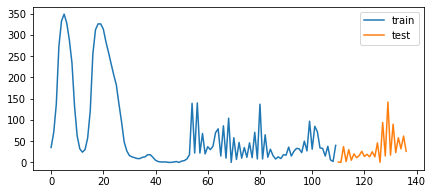

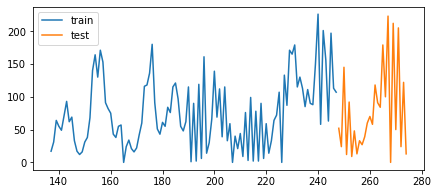

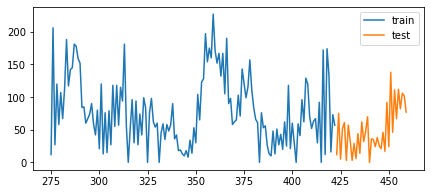

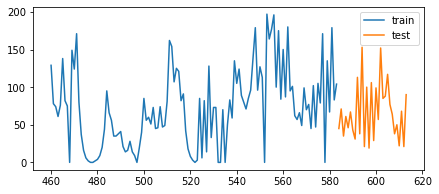

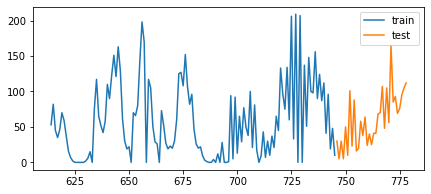

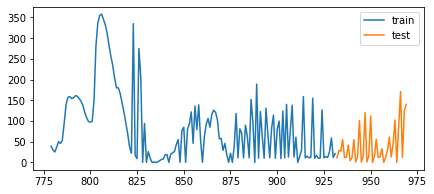

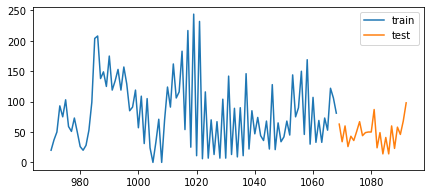

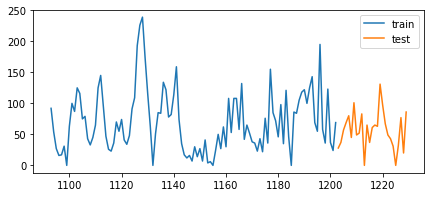

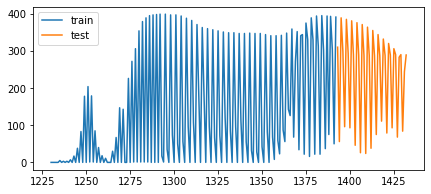

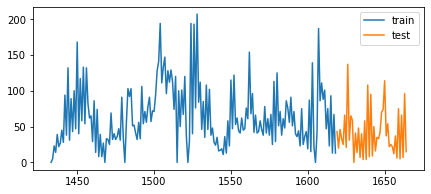

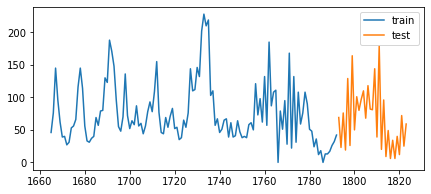

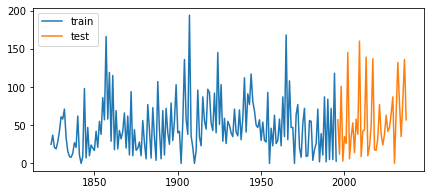

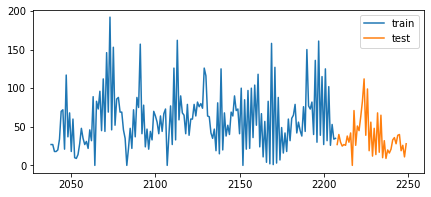

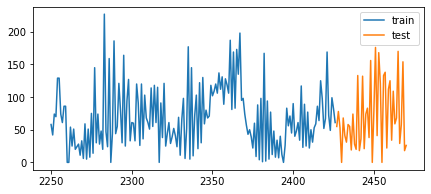

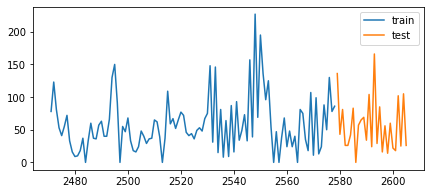

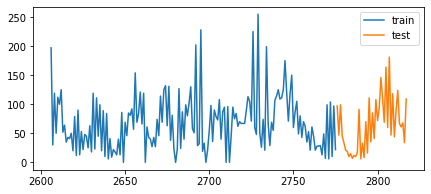

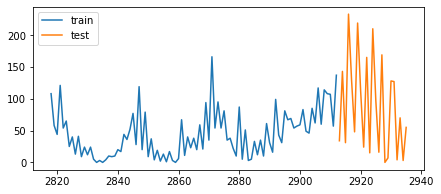

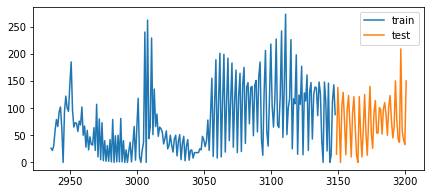

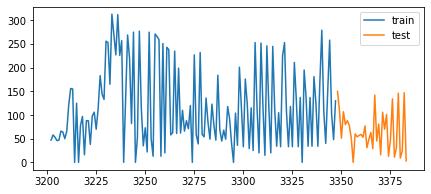

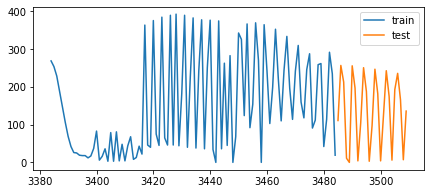

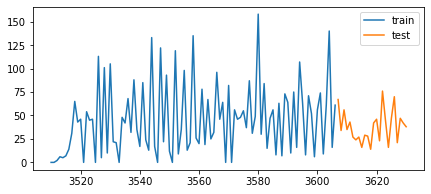

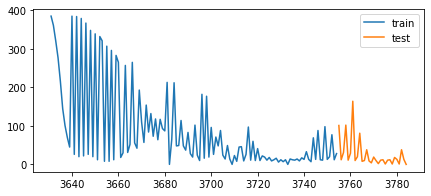

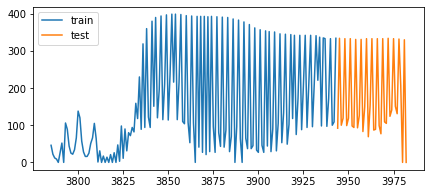

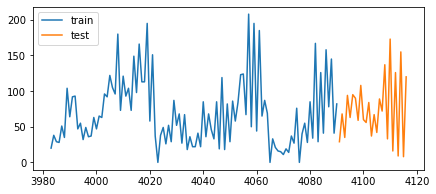

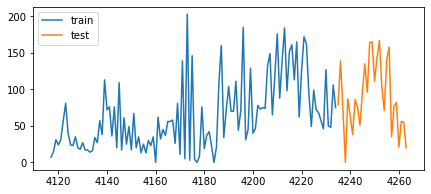

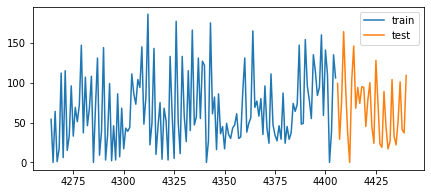

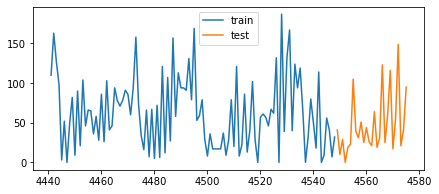

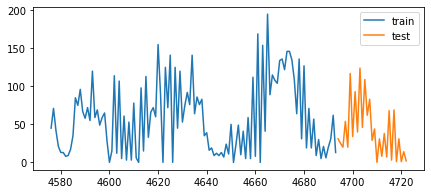

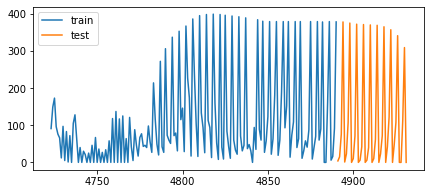

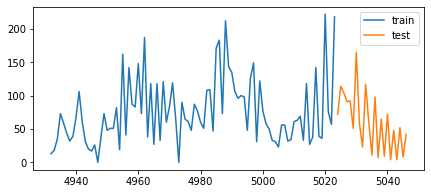

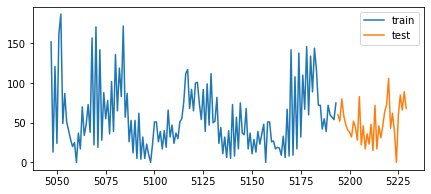

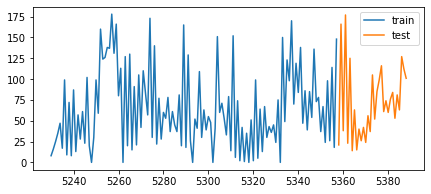

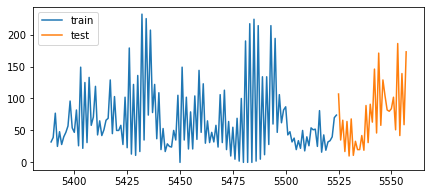

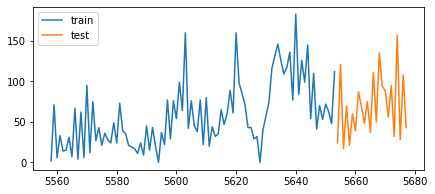

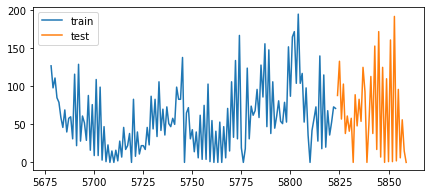

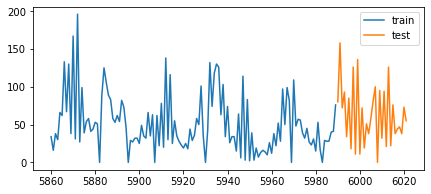

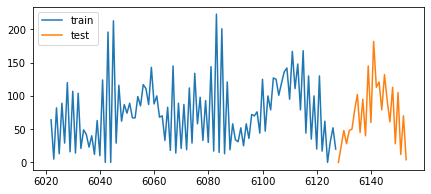

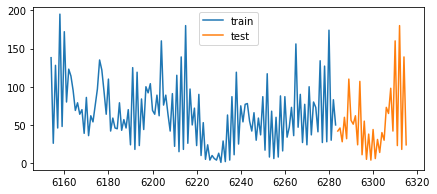

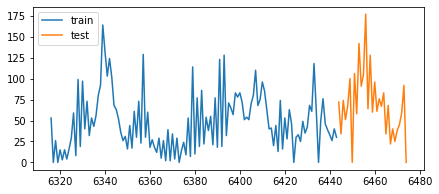

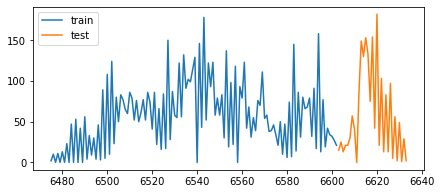

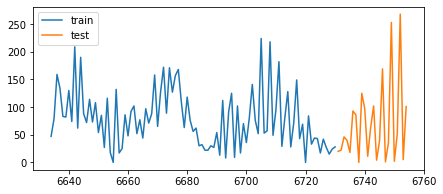

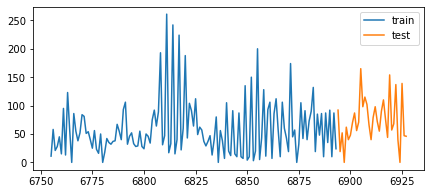

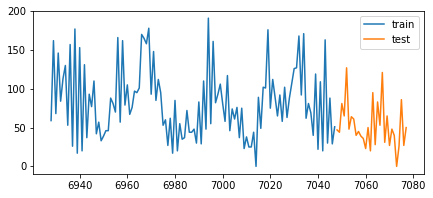

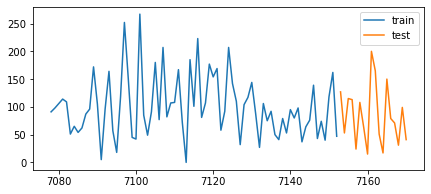

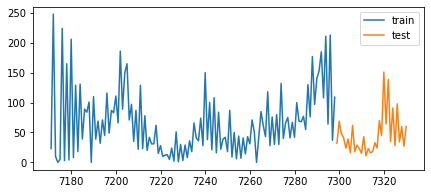

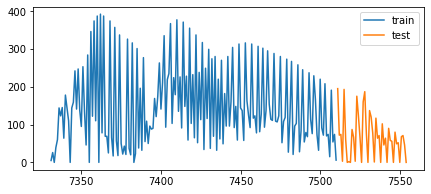

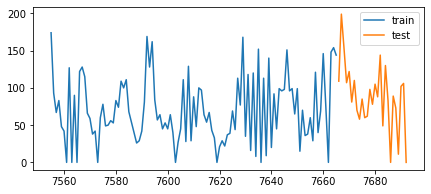

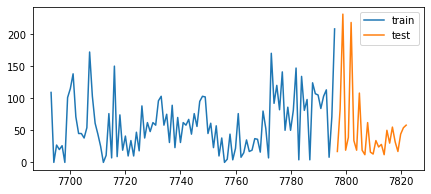

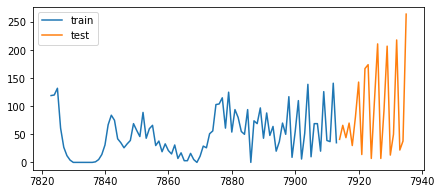

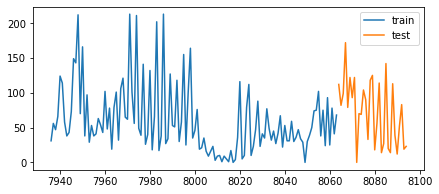

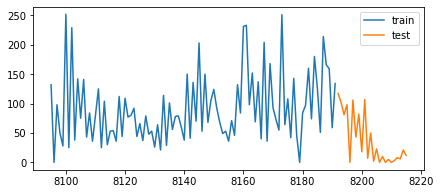

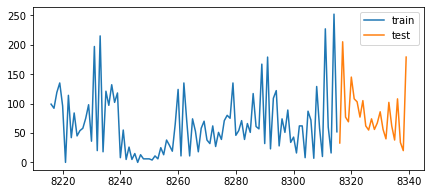

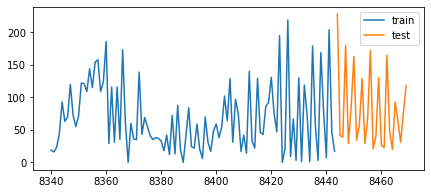

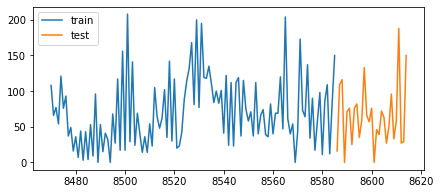

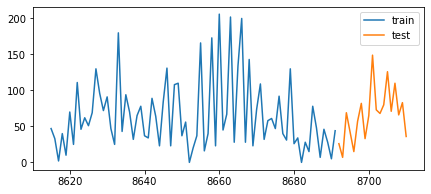

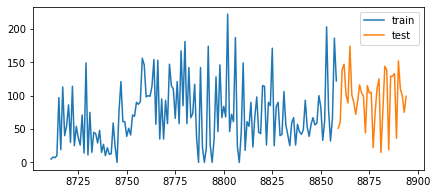

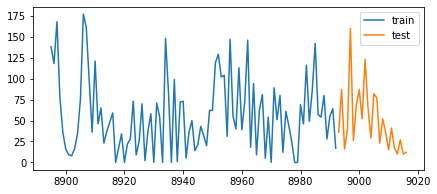

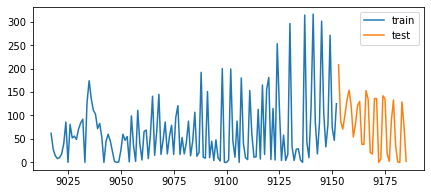

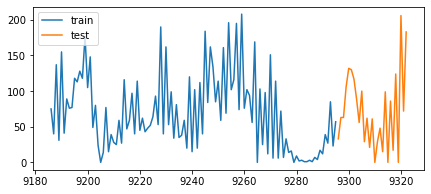

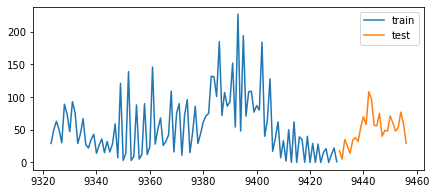

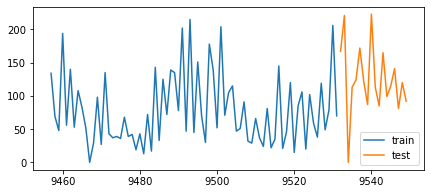

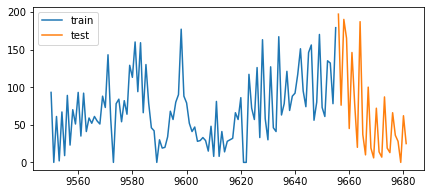

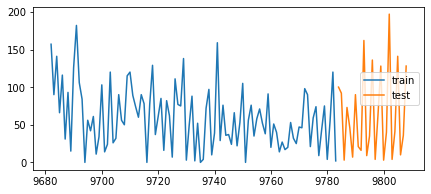

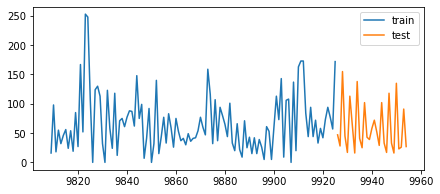

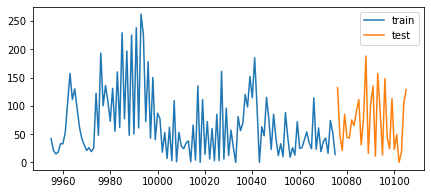

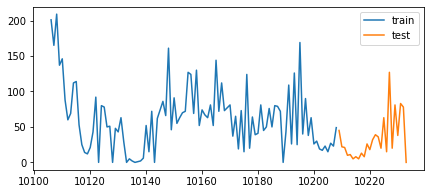

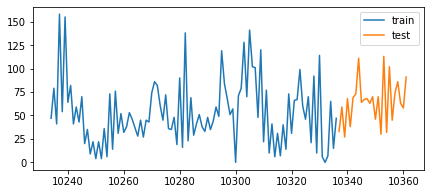

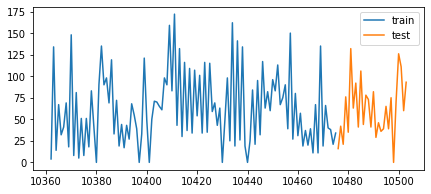

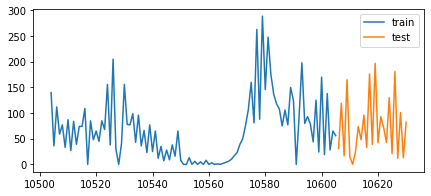

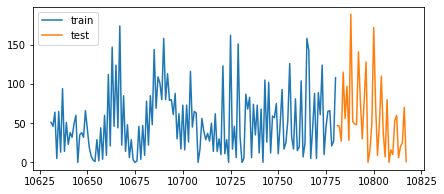

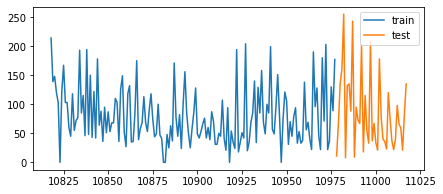

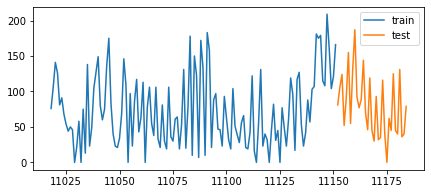

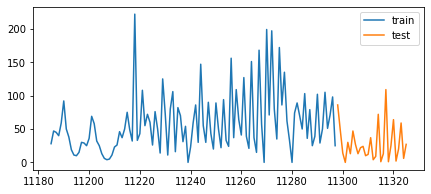

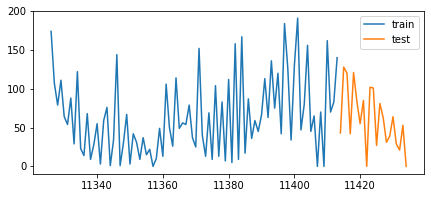

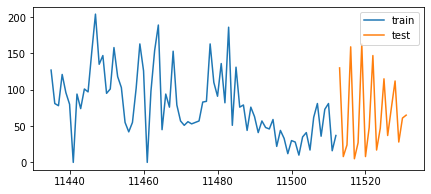

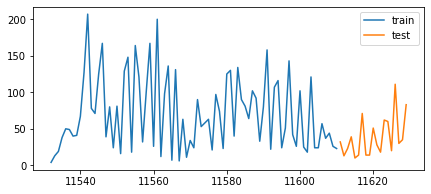

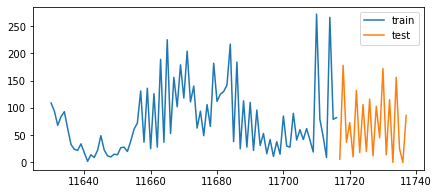

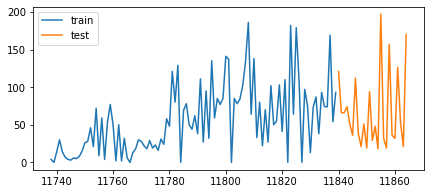

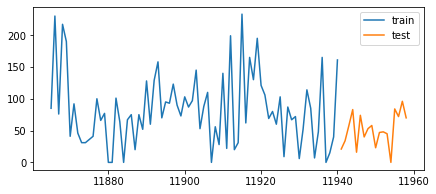

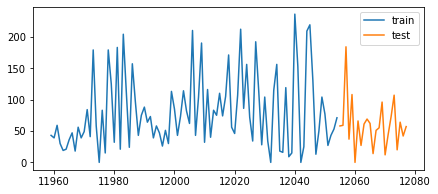

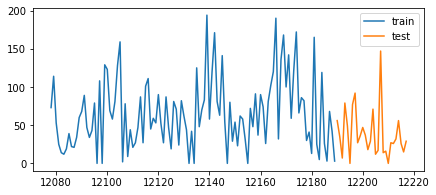

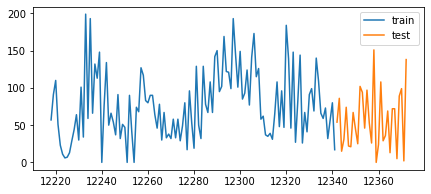

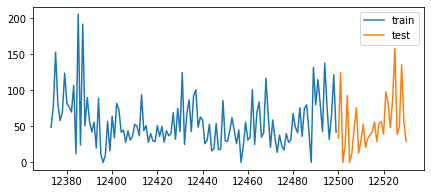

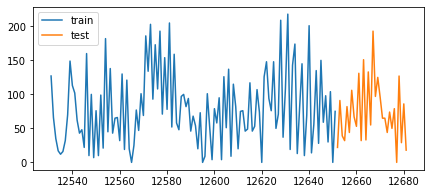

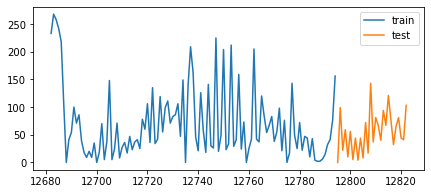

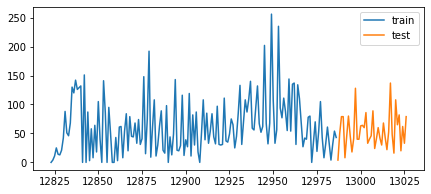

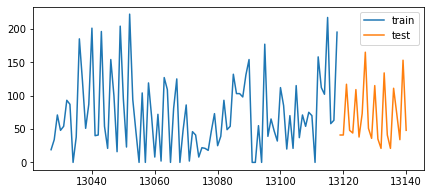

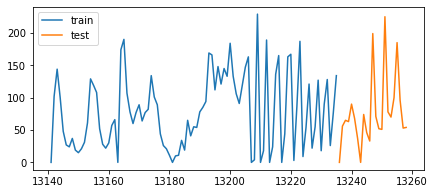

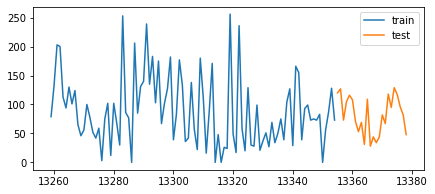

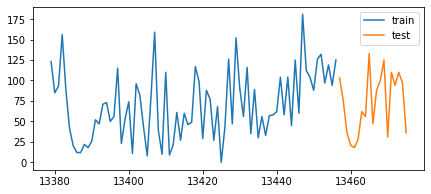

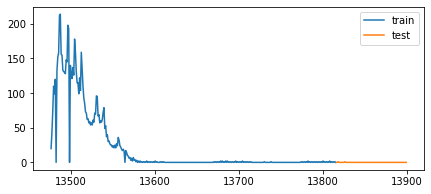

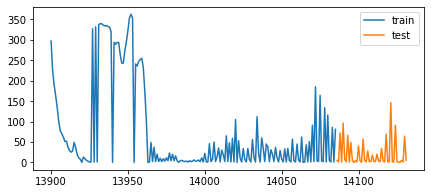

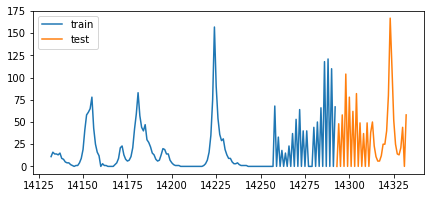

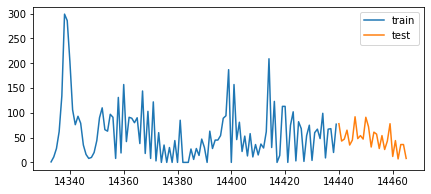

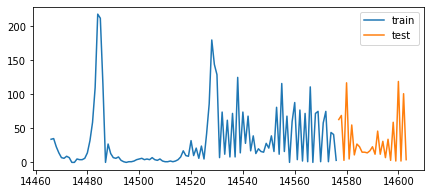

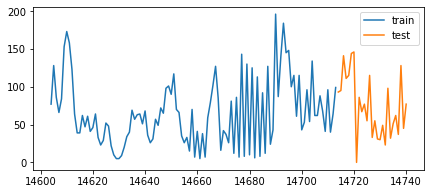

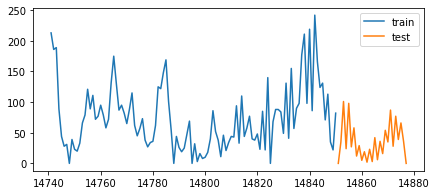

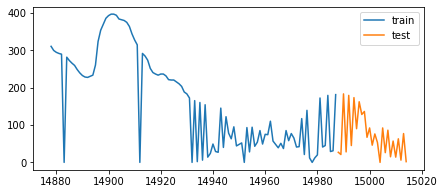

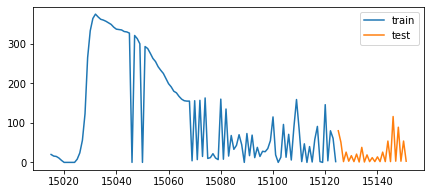

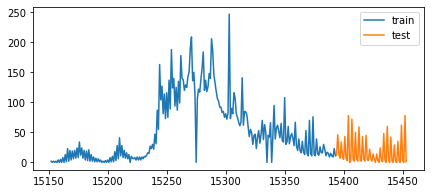

In [184]:
data_train = {}
data_test = {}
for prod in grouped_list:
    id_product = prod['product_number'].iloc[0]
    print(id_product)
    steps = int(len(prod['week']) * 0.2)
    #print(steps)
    data_train[id_product] = prod[:-steps]
    data_test[id_product] = prod[-steps:]

    print(f"Train dates : {data_train[id_product].index.min()} --- {data_train[id_product].index.max()}  (n={len(data_train[id_product])})")
    print(f"Test dates  : {data_test[id_product].index.min()} --- {data_test[id_product].index.max()}  (n={len(data_test[id_product])})")

    fig, ax = plt.subplots(figsize=(7, 3))
    data_train[id_product]['inventory_units'].plot(ax=ax, label='train')
    data_test[id_product]['inventory_units'].plot(ax=ax, label='test')
    ax.legend() 


In [185]:
forecaster = {}
for prod in grouped_list:
    id_product = prod['product_number'].iloc[0]
    steps = int(len(prod['week']) * 0.2)

    forecaster[id_product] = ForecasterAutoreg(regressor=RandomForestRegressor(random_state=123), lags=6)
    forecaster[id_product].fit(y=data_train[id_product]['inventory_units'])

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:626: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Users/mac/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:626: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Users/mac/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:626: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Users/mac/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:626: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Users/mac/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:626: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.w

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:684: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Users/mac/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:684: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Users/mac/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:684: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Users/mac/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:684: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Users/mac/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:684: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. In

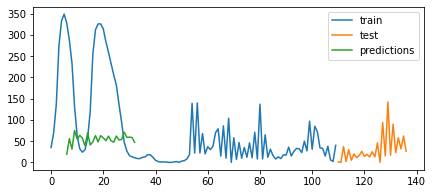

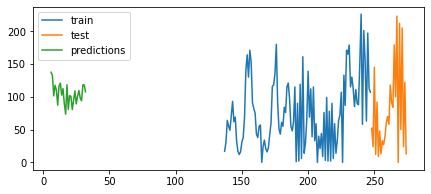

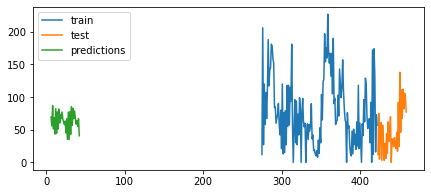

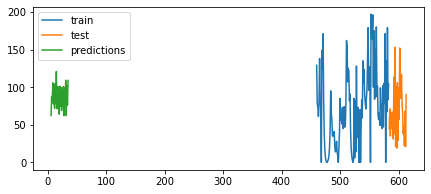

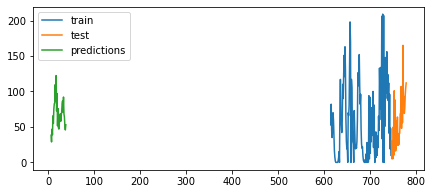

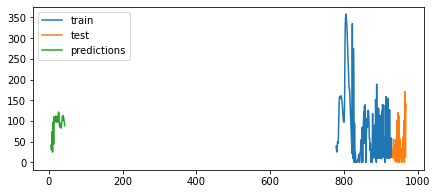

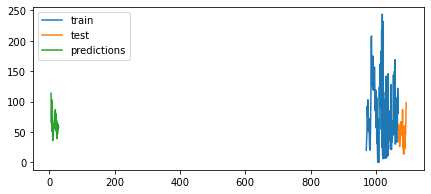

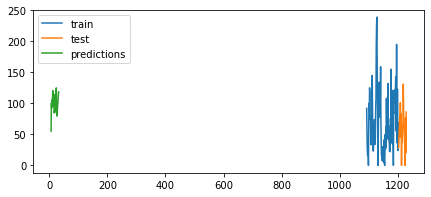

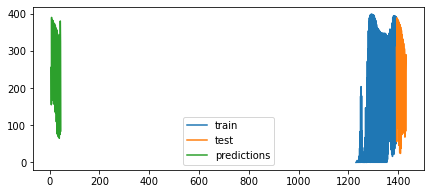

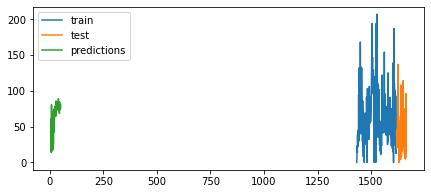

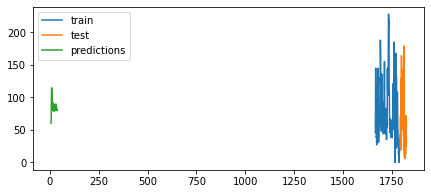

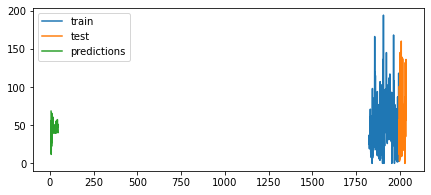

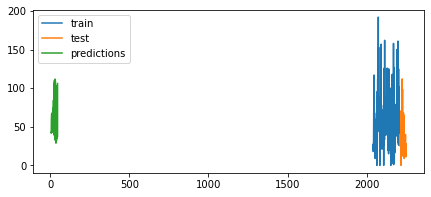

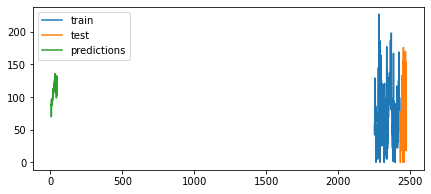

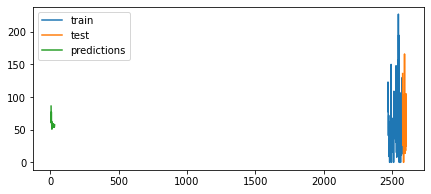

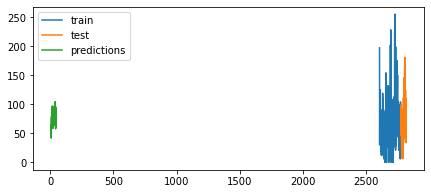

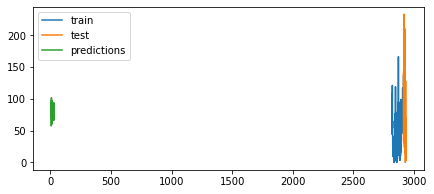

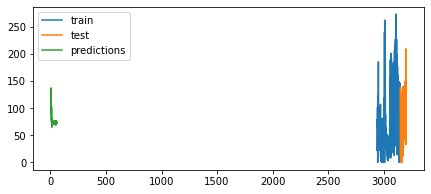

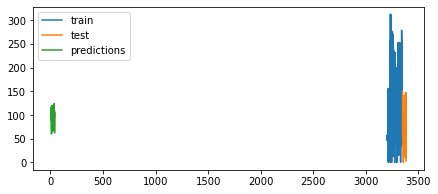

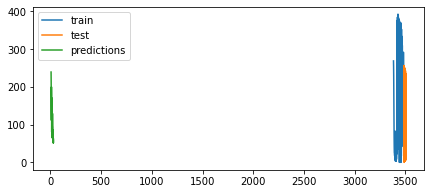

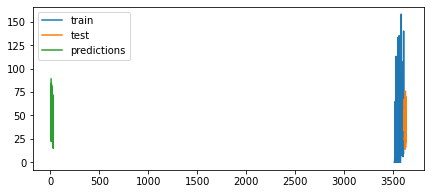

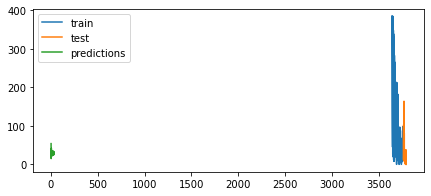

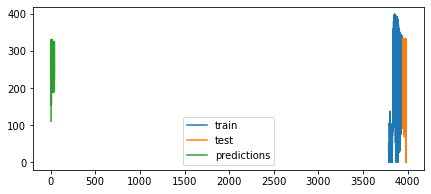

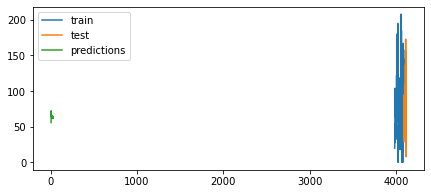

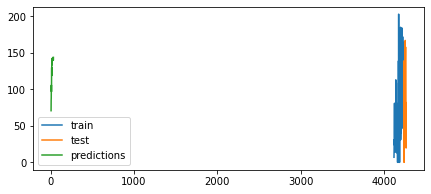

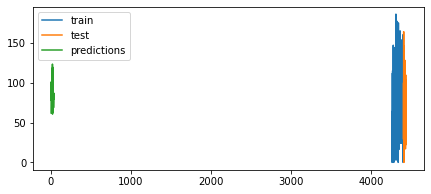

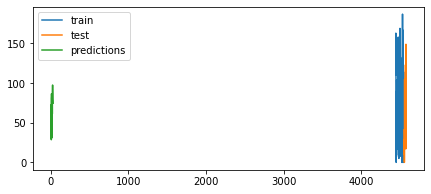

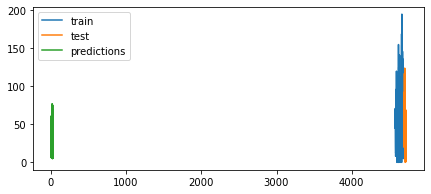

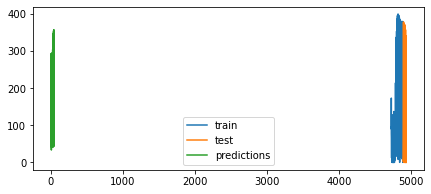

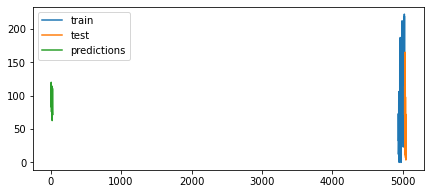

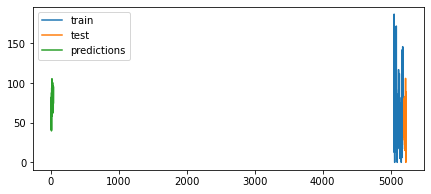

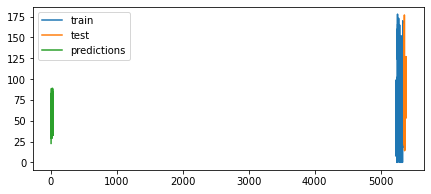

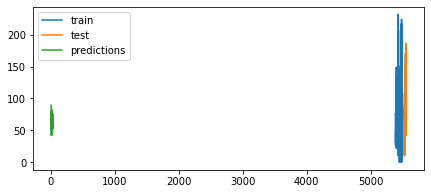

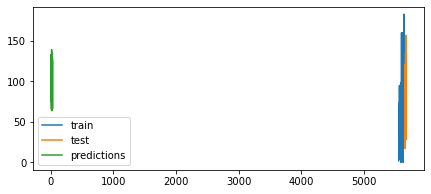

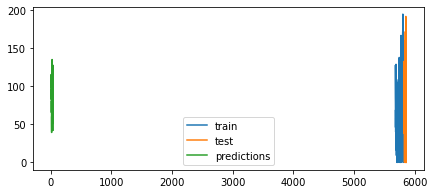

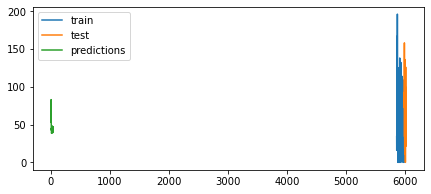

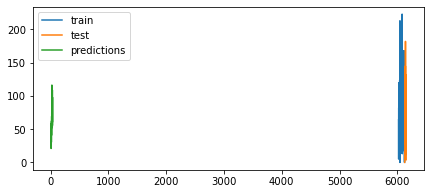

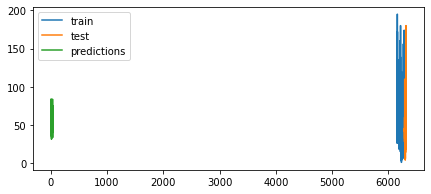

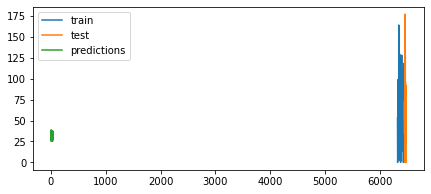

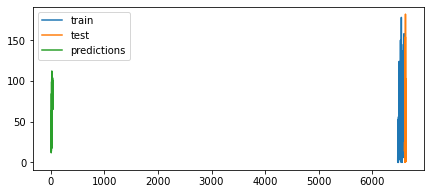

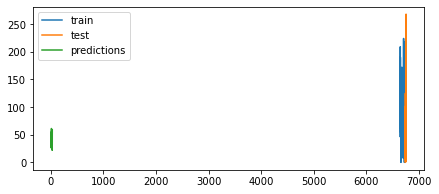

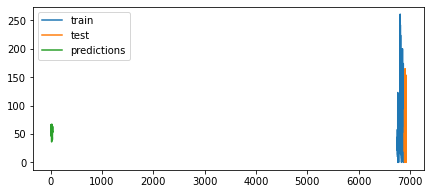

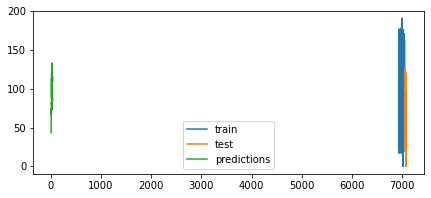

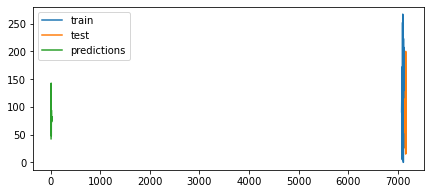

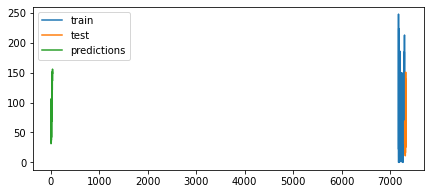

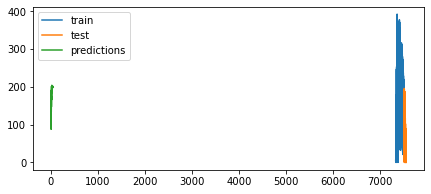

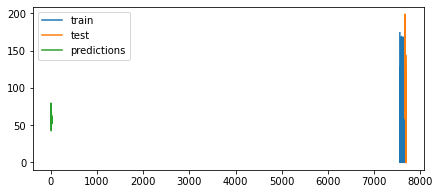

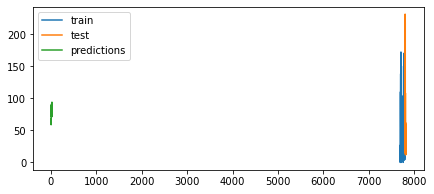

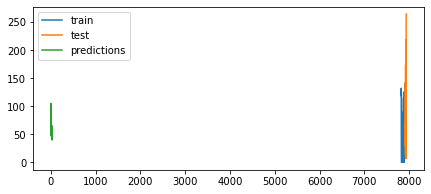

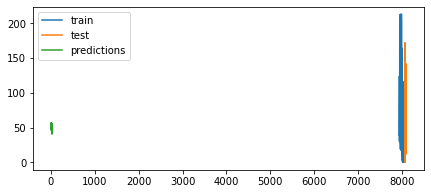

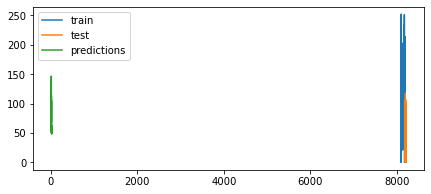

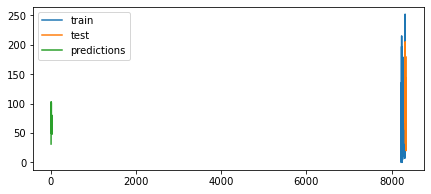

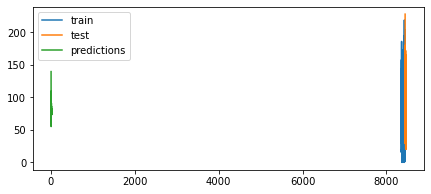

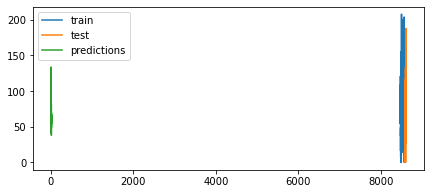

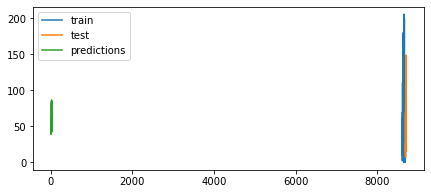

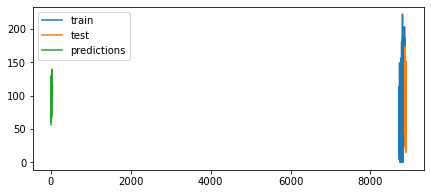

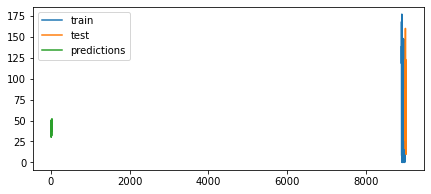

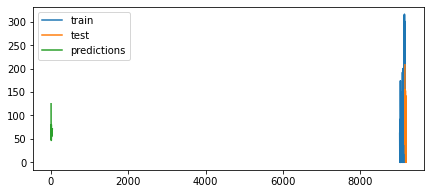

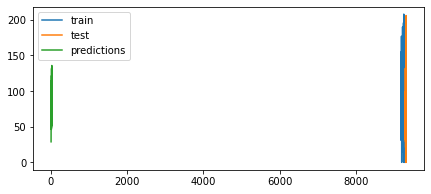

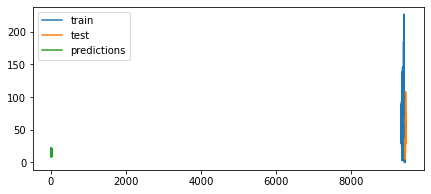

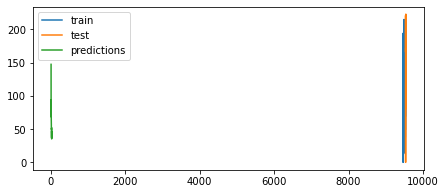

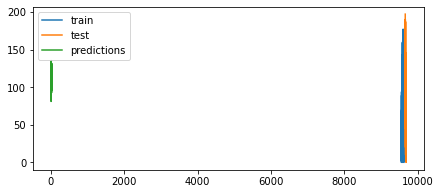

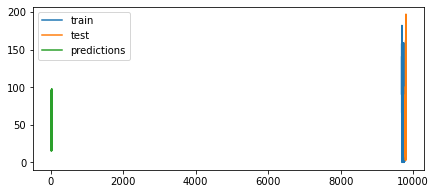

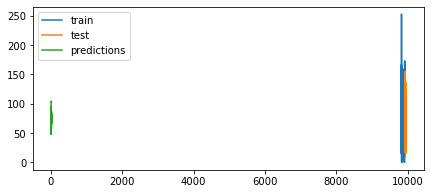

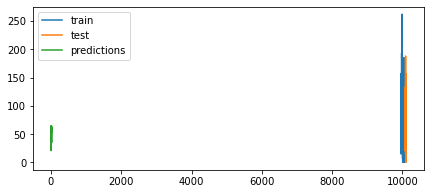

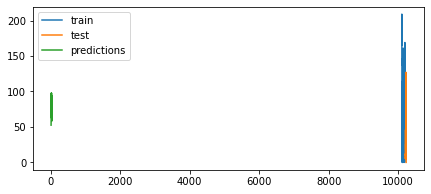

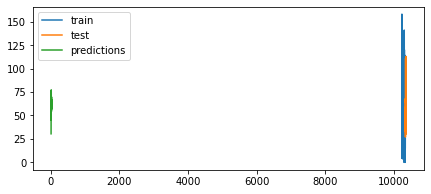

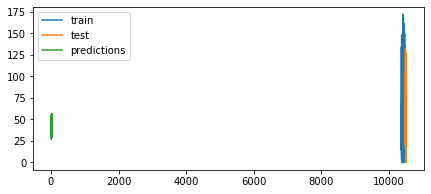

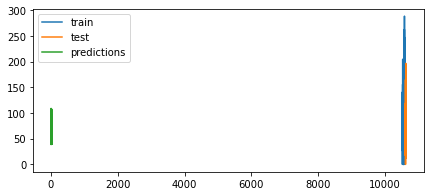

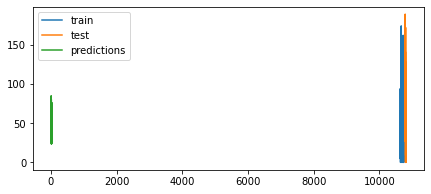

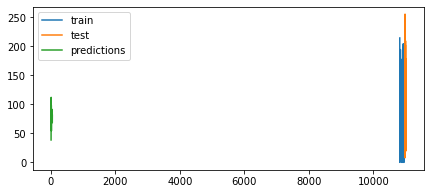

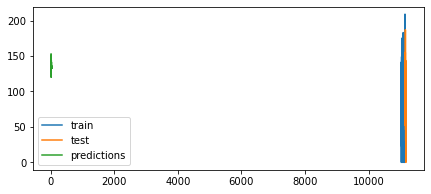

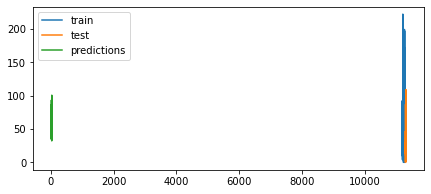

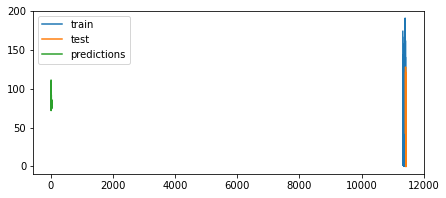

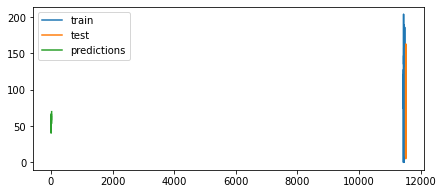

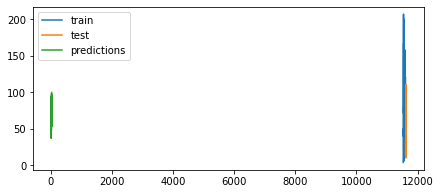

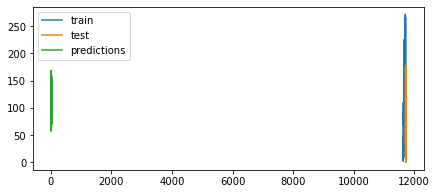

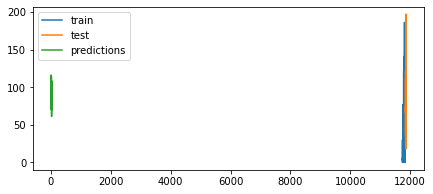

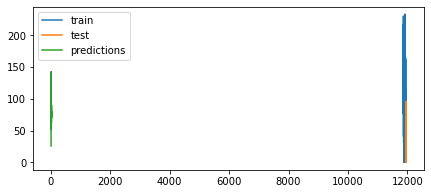

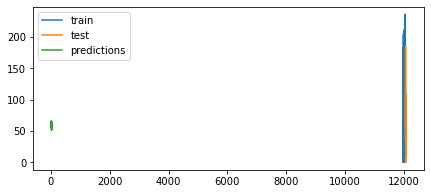

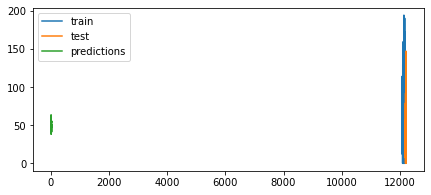

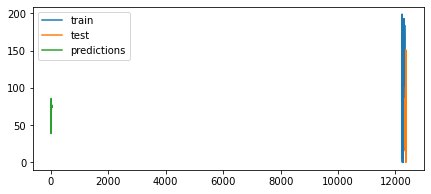

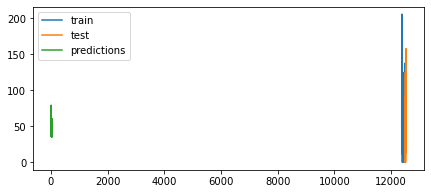

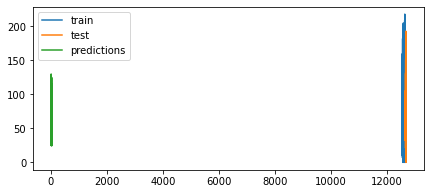

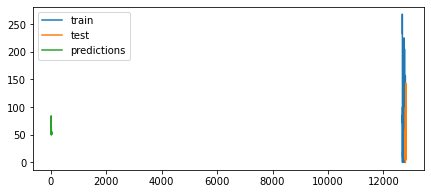

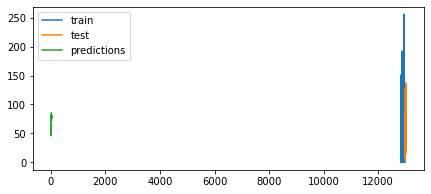

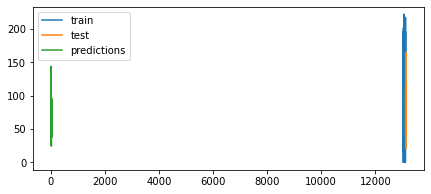

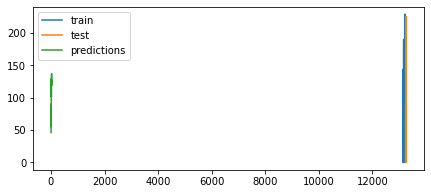

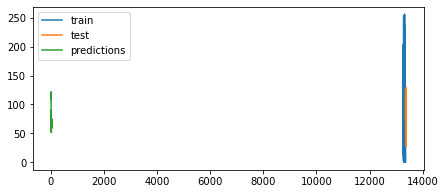

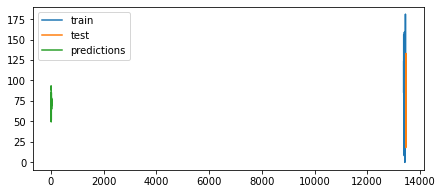

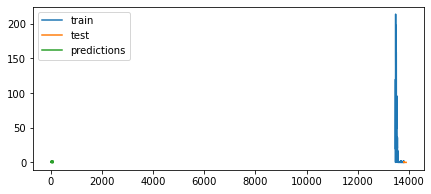

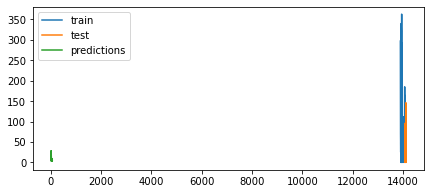

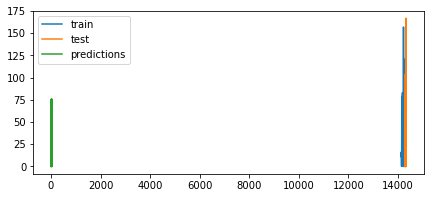

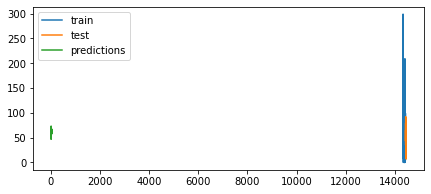

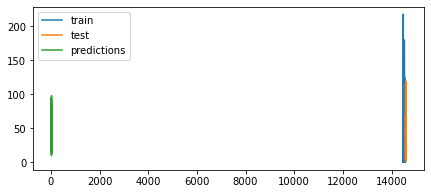

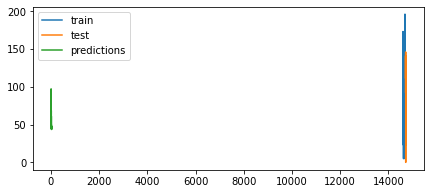

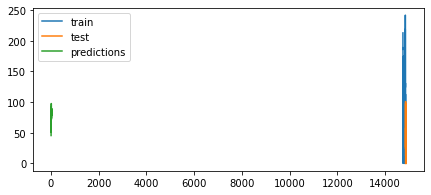

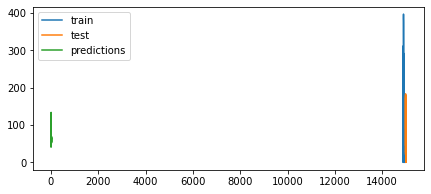

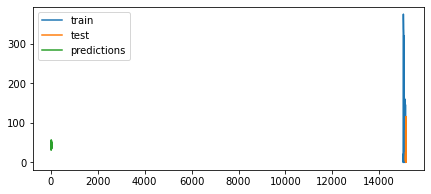

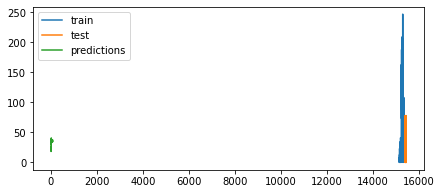

In [186]:
# Predictions
# ==============================================================================
for prod in grouped_list:
    id_product = prod['product_number'].iloc[0]
    steps = int(len(prod['week']) * 0.2)
    predictions = forecaster[id_product].predict(steps=steps)
    # Plot
    # ==============================================================================
    fig, ax = plt.subplots(figsize=(7, 3))
    data_train[id_product]['inventory_units'].plot(ax=ax, label='train')
    data_test[id_product]['inventory_units'].plot(ax=ax, label='test')
    predictions.plot(ax=ax, label='predictions')
    #predicted = forecaster[id_product].predict(steps=len(data_test[id_product]))
    ax.legend();

In [187]:
    # Test error
    # ==============================================================================
    error_mse = mean_squared_error(
                y_true = data_test[id_product]['inventory_units'],
                y_pred = predictions)

    print(f"Test error (mse): {math.sqrt(error_mse)}")

Test error (mse): 28.789235748800277


In [188]:
# Hyperparameter Grid search
# ==============================================================================
steps = int(len(prod['week']) * 0.2)
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [10, 20]

# Regressor's hyperparameters
param_grid = {'n_estimators': [50, 100, 200, 500],
              'max_depth': [3, 5, 7, 10],
              'max_features': ['auto', 'sqrt', 'log2']}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train[id_product]['inventory_units'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train[id_product])*0.7),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 96.


loop lags_grid:   0%|                                               | 0/2 [00:00<?, ?it/s]/Users/mac/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:626: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Users/mac/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:626: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Users/mac/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:684: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Users/mac/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:626: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Users/mac/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:626: UserWarning:

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 10, 'max_features': 'auto', 'n_estimators': 200}
  Backtesting metric: 1463.7011720118326



/Users/mac/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:626: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(


In [189]:
results_grid

lags  \
86  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
87  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
75  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
85  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
74  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
..                                                ...   
5                     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   
11                    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   
7                     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   
10                    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   
6                     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   

                                               params  mean_squared_error  \
86  {'max_depth': 10, 'max_features': 'auto', 'n_e...          1463.70117   
87  {'max_depth': 10, 'max_features': 'auto', 'n_e...          1471.97350   
75  {'max_depth': 7, 'max_features': 'auto', 'n_es...          1489.45909   
85  {'max_depth': 10, 'max_features': 'auto', 'n_e...          1510.98412   
74  {'max_depth': 7, 'max_features': 'auto', 'n_es...          1538.98718   
..                                                ...                 ...   
5   {'max_depth': 3, 'max_features': 'sqrt', 'n_es...          5638.44620   
11  {'max_depth': 3, 'max_features': 'log2', 'n_es...          5669.18055   
7   {'max_depth': 3, 'max_features': 'sqrt', 'n_es...          5669.18055   
10  {'max_depth': 3, 'max_features': 'log2', 'n_es...          6132.33145   
6   {'max_depth': 3, 'max_features': 'sqrt', 'n_es...          6132.33145   

    max_depth max_features  n_estimators  
86         10         auto           200  
87         10         auto           500  
75          7         auto           500  
85         10         auto           100  
74          7         auto           200  
..        ...          ...           ...  
5           3         sqrt           100  
11          3         log2           500  
7           3         sqrt           500  
10          3         log2           200  
6           3         sqrt           200  

[96 rows x 6 columns]

In [194]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=10, n_estimators=200, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )

forecaster.fit(y=data_train[id_product]['inventory_units'])

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:626: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Users/mac/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:626: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(


In [195]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:684: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(


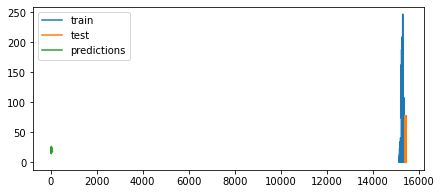

In [196]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train[id_product]['inventory_units'].plot(ax=ax, label='train')
data_test[id_product]['inventory_units'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [199]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test[id_product]['inventory_units'],
                y_pred = predictions
            )

print(f"Test error (mse): {math.sqrt(error_mse)}")

Test error (mse): 22.439346443798062
